#### Reinforcement Learning

##### Multi Armed Bandits - Epsilon Greedy and UCB 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

np.random.seed(7)

In [2]:
movies = pd.read_csv('movies.csv')
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


In [3]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [4]:
ratings = pd.read_csv('ratings.csv')
ratings

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434


In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [6]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [7]:
# check the amount of films

count_ratings = ratings.groupby('movieId', as_index=False)['userId'].count().rename(columns={'userId':'count'})
count_ratings = count_ratings.sort_values('count')
count_ratings

,movieId,count
29523,136782,1
34959,151011,1
34958,151001,1
34951,150962,1
34947,150950,1
...,...,...
2480,2571,72674
585,593,74127
292,296,79672
314,318,81482


Retirando filmes que tem menos de 5000 avaliações.

In [8]:
keep = count_ratings.loc[(count_ratings['count'] >= 5000), 'movieId'].values

len(keep)

1223

In [9]:
ratings = ratings.loc[(ratings['movieId'].isin(keep)), :].reset_index(drop=True)
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16358020 entries, 0 to 16358019
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 499.2 MB


Variável binária - valor 1 para filmes com avaliação maior que 3 e zero para aavaliação menor que 3.

In [10]:
ratings['binary_rating'] = [1 if x >= 3 else 0 for x in ratings['rating'].values]

ratings

,userId,movieId,rating,timestamp,binary_rating
0,1,296,5.0,1147880044,1
1,1,306,3.5,1147868817,1
2,1,307,5.0,1147868828,1
3,1,899,3.5,1147868510,1
4,1,1088,4.0,1147868495,1
...,...,...,...,...,...
16358015,162541,33794,4.0,1240951792,1
16358016,162541,41566,4.0,1240952749,1
16358017,162541,45517,4.5,1240953353,1
16358018,162541,50872,4.5,1240953372,1


In [11]:
# merge dataframes
df = pd.merge(ratings, movies, how='left', on='movieId')
df = pd.merge(df, count_ratings, how='left', on='movieId')
df

,userId,movieId,rating,timestamp,binary_rating,title,genres,count
0,1,296,5.0,1147880044,1,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,79672
1,1,306,3.5,1147868817,1,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama,7058
2,1,307,5.0,1147868828,1,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama,6616
3,1,899,3.5,1147868510,1,Singin' in the Rain (1952),Comedy|Musical|Romance,10895
4,1,1088,4.0,1147868495,1,Dirty Dancing (1987),Drama|Musical|Romance,11935
...,...,...,...,...,...,...,...,...
16358015,162541,33794,4.0,1240951792,1,Batman Begins (2005),Action|Crime|IMAX,30684
16358016,162541,41566,4.0,1240952749,1,"Chronicles of Narnia: The Lion, the Witch and ...",Adventure|Children|Fantasy,12518
16358017,162541,45517,4.5,1240953353,1,Cars (2006),Animation|Children|Comedy,8147
16358018,162541,50872,4.5,1240953372,1,Ratatouille (2007),Animation|Children|Drama,19157


Pivot table - users in the index and films in the columns

In [12]:
users = pd.pivot_table(df, index='userId', values='binary_rating', columns='title')
users = users.fillna(0)
users.head()

title,(500) Days of Summer (2009),10 Things I Hate About You (1999),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),12 Years a Slave (2013),127 Hours (2010),13 Going on 30 (2004),"13th Warrior, The (1999)","2 Fast 2 Furious (Fast and the Furious 2, The) (2003)",...,You've Got Mail (1998),Young Frankenstein (1974),Young Guns (1988),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# checking highest rated movies

positive = users.sum().to_frame().reset_index().rename(columns={'index':'movies', 0: 'positive evaluations'})
positive = positive.sort_values('positive evaluations', ascending=False).reset_index(drop=True)
positive

,title,positive evaluations
0,"Shawshank Redemption, The (1994)",79105.0
1,Forrest Gump (1994),75440.0
2,Pulp Fiction (1994),74297.0
3,"Silence of the Lambs, The (1991)",70495.0
4,"Matrix, The (1999)",67650.0
...,...,...
1218,"Island of Dr. Moreau, The (1996)",2445.0
1219,Charlie's Angels: Full Throttle (2003),2431.0
1220,Anaconda (1997),1771.0
1221,Super Mario Bros. (1993),1747.0


In [14]:
# amount of users

df['userId'].nunique()

162520

In [15]:
users = pd.DataFrame(users.to_records())
users.head()

,userId,(500) Days of Summer (2009),10 Things I Hate About You (1999),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),12 Years a Slave (2013),127 Hours (2010),13 Going on 30 (2004),"13th Warrior, The (1999)",...,You've Got Mail (1998),Young Frankenstein (1974),Young Guns (1988),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
users.drop(columns='userId', inplace=True)
users.head()

,(500) Days of Summer (2009),10 Things I Hate About You (1999),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),12 Years a Slave (2013),127 Hours (2010),13 Going on 30 (2004),"13th Warrior, The (1999)","2 Fast 2 Furious (Fast and the Furious 2, The) (2003)",...,You've Got Mail (1998),Young Frankenstein (1974),Young Guns (1988),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162520 entries, 0 to 162519
Columns: 1223 entries, (500) Days of Summer (2009) to ¡Three Amigos! (1986)
dtypes: float64(1223)
memory usage: 1.5 GB


Experiment to check randomized recommendations

In [18]:
num_users = len(users)
num_movies = len(users.columns)
movies_selected = []
numbers_of_selections = [0] * num_movies
mean_reward = []
cummulative_total_reward = []
total_reward = 0
batch_size = 170
iteration = 1

# 500x replay
for replay in tqdm(range(500)):
  for n in range(0, num_users, batch_size): # 
    # raffles the film to recommend to the user
    movies = np.random.choice(num_movies, size=5, replace=False)
    for movie in movies:
      movies_selected.append(movie) # stores recommended movies
      numbers_of_selections[movie] += batch_size # adds the count to the number of times the movie was selected
    # The reward is calculated by adding up the total positive ratings for each film's batch
    reward = sum([users.values[n:n+batch_size, movie].sum() for movie in movies])
    # Soma a recompensa conseguida pelo agente à recompensa total
    total_reward += reward 
    # Adds the agent's reward to the total reward
    cummulative_total_reward.append(total_reward)
    # adds the average reward to the average rewards list
    mean_reward.append(total_reward / (iteration * batch_size)) # the average reward: total reward divided by the number of iterations times the number of referrals each iteration
    iteration += 1

100%|██████████| 500/500 [00:42<00:00, 11.89it/s]


In [19]:
print('total reward: ', total_reward)

total reward:  28553867.0


In [20]:
print('Most selected film: ', users.columns.to_list()[np.argmax(numbers_of_selections)])

Most selected film:  Englishman Who Went Up a Hill But Came Down a Mountain, The (1995)


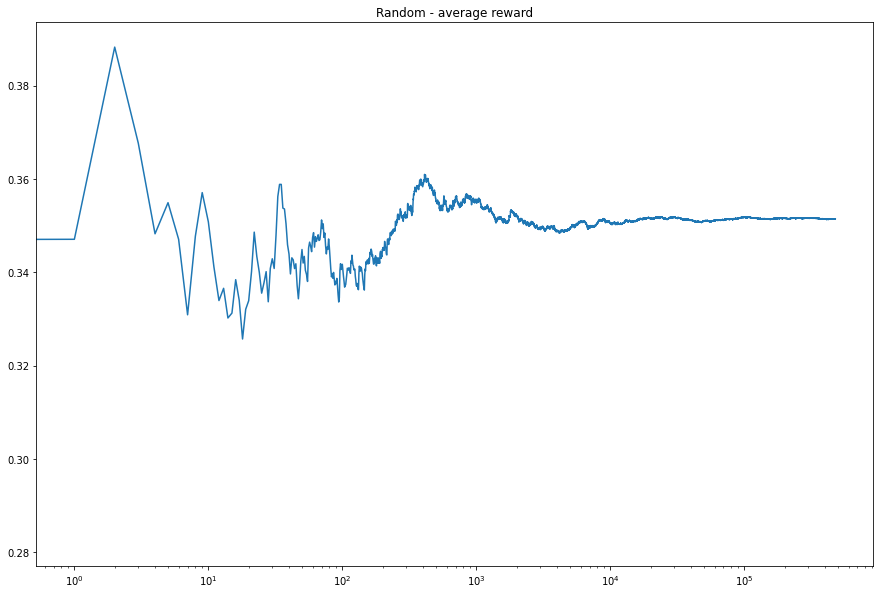

In [21]:
plt.figure(figsize=(15, 10))
plt.plot(mean_reward)
plt.xscale('log')
plt.title('Random - average reward')
plt.show()

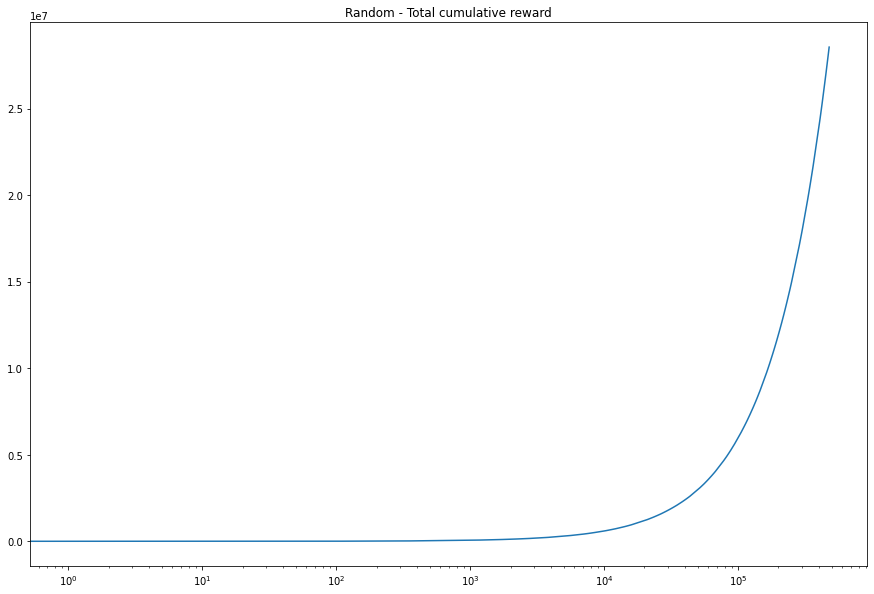

In [22]:
plt.figure(figsize=(15, 10))
plt.plot(cummulative_total_reward)
plt.xscale('log')
plt.title('Random - Total cumulative reward')
plt.show()

## $\epsilon$-greedy

In [23]:
num_users = len(users)
num_movies = len(users.columns)
e_values = {0: [], 0.01: [], 0.1:[], 0.4:[], 0.7:[], 1:[]}
exploi_explor = [0, 1] # values ​​that will be sampled with epsilon probabilities to simulate the actions of 0=exploit and 1=explore
batch_size = 170

for e, results in tqdm(e_values.items()): # iterates over a dictionary with the different epsilon values ​​and stores the results for each value
  movies_selected = [] # stores the selected movies in each iteration
  numbers_of_selections = [0] * num_movies # number of selections from each film
  sums_of_reward = [0] * num_movies # total reward of each movie
  mean_reward = [0] * num_movies # average reward of each movie
  total_mean_reward = [] # average reward of each iteration
  cummulative_total_reward = [] # total accumulated reward
  total_reward = 0
  iteration = 1
  
  for replay in range(500):
    for n in range(0, num_users, batch_size):
      action = np.random.choice(exploi_explor, 1, p=[1-e, e]) # draws between exploit actions explore with exploit probability = 1-epsilon and explore=epsilon
      if action == 0: # exploit action
        if not movies_selected: # if no film was chosen, start by indicating films from 0 to 4
          movies = [0, 1, 2, 3, 4]
        else:
          movies = sorted(range(num_movies), key=lambda m: mean_reward[m], reverse=True)[:5] # exploit movie that has the highest average rewards to date
      
      else: # ação de explore
        if not movies_selected: # if no film was chosen, start by indicating films from 0 to 4
          movies = [0, 1, 2, 3, 4]
        else:
          movies = np.random.choice(num_movies, size=5, replace=False) # draws 5 films to explore; continues raffling until choosing films other than those that currently have the highest average reward
          while (set(movies) & set(sorted(range(num_movies), key=lambda m: mean_reward[m], reverse=True)[:5])): # checks if the lists contain at least 1 movie in common
            movies = np.random.choice(num_movies, size=5, replace=False)
      
      rewards = []
      for movie in movies:
        movies_selected.append(movie)
        numbers_of_selections[movie] += batch_size
        reward = users.values[n:n+batch_size, movie].sum()
        sums_of_reward[movie] += reward
        rewards.append(reward)
        mean_reward[movie] = sums_of_reward[movie] / numbers_of_selections[movie]
      
      total_reward += sum(rewards)
      total_mean_reward.append(total_reward / (iteration * batch_size))
      cummulative_total_reward.append(total_reward)
      iteration += 1     


  results.append(total_reward)
  results.append(total_mean_reward)
  results.append(mean_reward)
  results.append(numbers_of_selections)
  results.append(sums_of_reward)
  results.append(cummulative_total_reward)

print('')
print('')
print('total reward e=0.01: ', e_values[0][0],
      'total reward e=0.05: ', e_values[0.01][0],
      'total reward e=0.1: ', e_values[0.1][0], 
      'total reward e=0.4: ', e_values[0.4][0], 
      'total reward e=0.7: ', e_values[0.7][0],
      'total reward e=1: ', e_values[1][0])

100%|██████████| 6/6 [22:45<00:00, 227.62s/it]



total reward e=0.01:  25230000.0 total reward e=0.05:  178302132.0 total reward e=0.1:  167615923.0 total reward e=0.4:  121217757.0 total reward e=0.7:  74759083.0 total reward e=1:  27915468.0


In [24]:
print('total reward e=0: ', e_values[0][0])
print('Most selected film e=0: ', users.columns.to_list()[np.argmax(e_values[0][3])])
print('-> Number of selections of the most selected movie: ', e_values[0][3][np.argmax(e_values[0][3])])
print('Top 5 filmes e=0: ', [users.columns.to_list()[m] for m in sorted(range(num_movies), key=lambda m: e_values[0][3][m], reverse=True)[:5]])
print('')
print('total reward e=0.01: ', e_values[0.01][0])
print('Most selected film e=0.01: ', users.columns.to_list()[np.argmax(e_values[0.01][3])])
print('-> Number of selections of the most selected movie: ', e_values[0.01][3][np.argmax(e_values[0.01][3])])
print('Top 5 e=0.01: ', [users.columns.to_list()[m] for m in sorted(range(num_movies), key=lambda m: e_values[0.01][3][m], reverse=True)[:5]])
print('')
print('total reward e=0.1: ', e_values[0.1][0])
print('Most selected film e=0.1: ', users.columns.to_list()[np.argmax(e_values[0.1][3])])
print('-> Number of selections of the most selected movie: ', e_values[0.1][3][np.argmax(e_values[0.1][3])])
print('Top 5 e=0.1: ', [users.columns.to_list()[m] for m in sorted(range(num_movies), key=lambda m: e_values[0.1][3][m], reverse=True)[:5]])
print('')
print('total reward e=0.4: ', e_values[0.4][0])
print('Most selected film e=0.4: ', users.columns.to_list()[np.argmax(e_values[0.4][3])])
print('-> Number of selections of the most selected movie: ', e_values[0.4][3][np.argmax(e_values[0.4][3])])
print('Top 5 e=0.4: ', [users.columns.to_list()[m] for m in sorted(range(num_movies), key=lambda m: e_values[0.4][3][m], reverse=True)[:5]])
print('')
print('total reward e=0.7: ', e_values[0.7][0])
print('Most selected film e=0.7: ', users.columns.to_list()[np.argmax(e_values[0.7][3])])
print('-> Number of selections of the most selected movie: ', e_values[0.7][3][np.argmax(e_values[0.7][3])])
print('Top 5 e=0.7: ', [users.columns.to_list()[m] for m in sorted(range(num_movies), key=lambda m: e_values[0.7][3][m], reverse=True)[:5]])
print('')
print('total reward e=1: ', e_values[1][0])
print('Most selected film e=1: ', users.columns.to_list()[np.argmax(e_values[1][3])])
print('-> Number of selections of the most selected movie: ', e_values[1][3][np.argmax(e_values[1][3])])
print('Top 3 e=1: ', [users.columns.to_list()[m] for m in sorted(range(num_movies), key=lambda m: e_values[1][3][m], reverse=True)[:5]])


total reward e=0:  25230000.0
Most selected film e=0:  (500) Days of Summer (2009)
-> Number of selections of the most selected movie:  81260000
Top 5 filmes e=0:  ['(500) Days of Summer (2009)', '10 Things I Hate About You (1999)', '101 Dalmatians (1996)', '101 Dalmatians (One Hundred and One Dalmatians) (1961)', '12 Angry Men (1957)']

total reward e=0.01:  178302132.0
Most selected film e=0.01:  Silence of the Lambs, The (1991)
-> Number of selections of the most selected movie:  80392320
Top 5 e=0.01:  ['Silence of the Lambs, The (1991)', 'Forrest Gump (1994)', 'Pulp Fiction (1994)', 'Matrix, The (1999)', 'Shawshank Redemption, The (1994)']

total reward e=0.1:  167615923.0
Most selected film e=0.1:  Pulp Fiction (1994)
-> Number of selections of the most selected movie:  73035910
Top 5 e=0.1:  ['Pulp Fiction (1994)', 'Forrest Gump (1994)', 'Matrix, The (1999)', 'Shawshank Redemption, The (1994)', 'Silence of the Lambs, The (1991)']

total reward e=0.4:  121217757.0
Most selected f

Charts

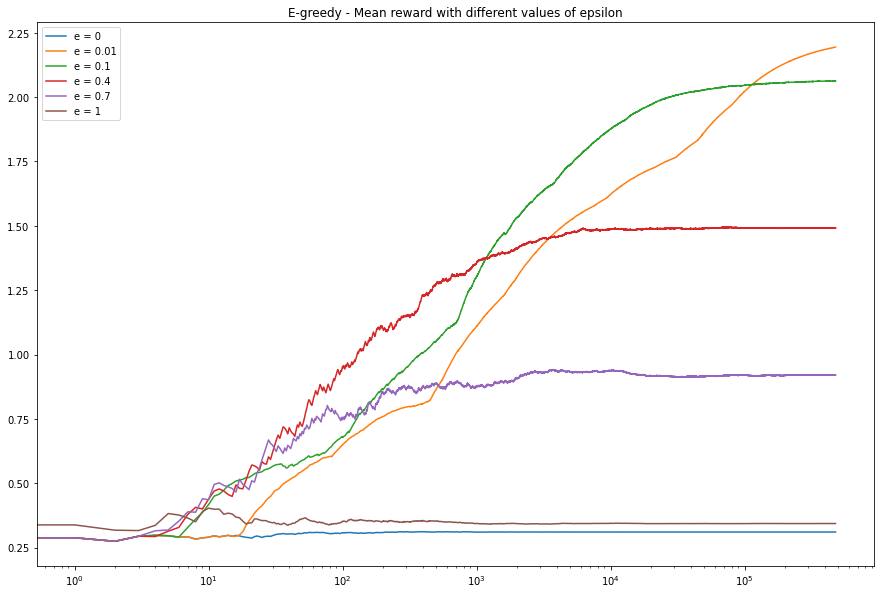

In [25]:
plt.figure(figsize=(15, 10))
plt.plot(e_values[0][1], label = "e = 0")
plt.plot(e_values[0.01][1], label = "e = 0.01")
plt.plot(e_values[0.1][1], label = "e = 0.1")
plt.plot(e_values[0.4][1], label = "e = 0.4")
plt.plot(e_values[0.7][1], label = "e = 0.7")
plt.plot(e_values[1][1], label = "e = 1")
plt.title('E-greedy - Mean reward with different values of epsilon')
plt.xscale('log')
plt.legend()
plt.show()

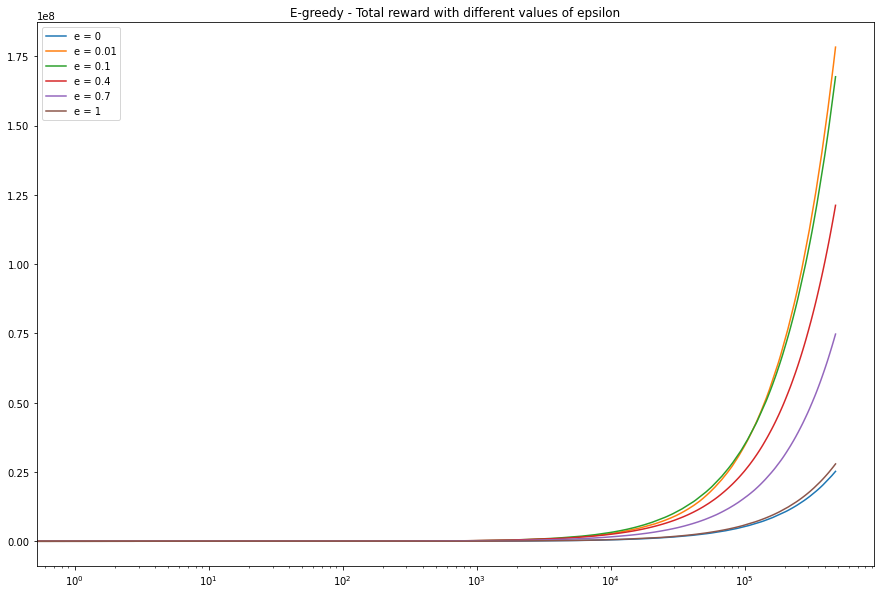

In [26]:
plt.figure(figsize=(15, 10))
plt.plot(e_values[0][5], label = "e = 0")
plt.plot(e_values[0.01][5], label = "e = 0.01")
plt.plot(e_values[0.1][5], label = "e = 0.1")
plt.plot(e_values[0.4][5], label = "e = 0.4")
plt.plot(e_values[0.7][5], label = "e = 0.7")
plt.plot(e_values[1][5], label = "e = 1")
plt.title('E-greedy - Total reward with different values of epsilon')
plt.xscale('log')
plt.legend()
plt.show()

Estratégia UCB

In [27]:
num_iterations = len(users)
num_movies = len(users.columns)
c_values = {0.01:[], 1:[], 3:[], 6:[], 10:[]} # dictionary with the different values ​​of c
batch_size = 170

for c, results in tqdm(c_values.items()):
  movies_selected = [] # movie selected in each iteration
  numbers_of_selections = [0] * num_movies # number of selections from each film
  sums_of_reward = [0] * num_movies # total reward of each movie
  mean_reward = [0] * num_movies # average reward of each movie
  total_mean_reward = [] # average reward of each iteration
  cummulative_total_reward = [] # total accumulated reward
  upper_bounds = [0] * num_movies # stores the upper_bound of each movie
  total_reward = 0
  iteration = 1
  
  for replay in range(500):
    for n in range(0, num_iterations, batch_size):
      movie = 0
      for i in range(0, num_movies):
        if (numbers_of_selections[i] > 0): # checks if the movie has already been selected and updates its upper bound
          average_reward = sums_of_reward[i] / numbers_of_selections[i]
          delta_i = c * math.sqrt(math.log(n+1) / numbers_of_selections[i])
          upper_bound = average_reward + delta_i
          upper_bounds[i] = upper_bound
        else:
          upper_bound = 1e400 # if the movie was not selected, the upper bound is infinite
          upper_bounds[i] = upper_bound
      
      movies = sorted(range(num_movies), key=lambda m: upper_bounds[m], reverse=True)[:5] # selects the 5 films with the highest upper_bound
      
      rewards = []
      for movie in movies:
        movies_selected.append(movie)
        numbers_of_selections[movie] += batch_size
        reward = users.values[n:n+batch_size, movie].sum()
        sums_of_reward[movie] += reward
        rewards.append(reward)
        mean_reward[movie] = sums_of_reward[movie] / numbers_of_selections[movie]
      
      total_reward += sum(rewards)
      total_mean_reward.append(total_reward / (iteration * batch_size))
      cummulative_total_reward.append(total_reward)
      iteration += 1    


  results.append(total_reward)
  results.append(total_mean_reward)
  results.append(mean_reward)
  results.append(numbers_of_selections)
  results.append(sums_of_reward)
  results.append(cummulative_total_reward)

print('')
print('')
print('total reward c=0.01: ', c_values[0.01][0], 
      'total reward c=1: ', c_values[1][0], 
      'total reward c=3: ', c_values[3][0], 
      'total reward c=6: ', c_values[6][0], 
      'total reward c=10: ', c_values[10][0])

100%|██████████| 5/5 [1:11:41<00:00, 860.40s/it]



total reward c=0.01:  183414278.0 total reward c=1:  183407262.0 total reward c=3:  183026320.0 total reward c=6:  181766852.0 total reward c=10:  178823471.0


In [28]:
print('total reward c=0.01: ', c_values[0.01][0])
print('Most selected film c=0.1: ', users.columns.to_list()[np.argmax(c_values[0.01][3])])
print('-> Number of selections of the most selected movie: ', c_values[0.01][3][np.argmax(c_values[0.01][3])])
print('Top 5 filmes c=0.1: ', [users.columns.to_list()[m] for m in sorted(range(num_movies), key=lambda m: c_values[0.01][3][m], reverse=True)[:5]])
print('')
print('total reward c=1: ', c_values[1][0])
print('Most selected film c=1: ', users.columns.to_list()[np.argmax(c_values[1][3])])
print('-> Number of selections of the most selected movie: ', c_values[1][3][np.argmax(c_values[1][3])])
print('Top 5 c=1: ', [users.columns.to_list()[m] for m in sorted(range(num_movies), key=lambda m: c_values[1][3][m], reverse=True)[:5]])
print('')
print('total reward c=3: ', c_values[3][0])
print('Most selected film c=3: ', users.columns.to_list()[np.argmax(c_values[3][3])])
print('-> Number of selections of the most selected movie: ', c_values[3][3][np.argmax(c_values[3][3])])
print('Top 5 c=3: ', [users.columns.to_list()[m] for m in sorted(range(num_movies), key=lambda m: c_values[3][3][m], reverse=True)[:5]])
print('')
print('total reward c=6: ', c_values[6][0])
print('Most selected film c=6: ', users.columns.to_list()[np.argmax(c_values[6][3])])
print('-> Number of selections of the most selected movie: ', c_values[6][3][np.argmax(c_values[6][3])])
print('Top 5 c=6: ', [users.columns.to_list()[m] for m in sorted(range(num_movies), key=lambda m: c_values[6][3][m], reverse=True)[:5]])
print('')
print('total reward c=10: ', c_values[10][0])
print('Most selected film c=10: ', users.columns.to_list()[np.argmax(c_values[10][3])])
print('-> Number of selections of the most selected movie: ', c_values[10][3][np.argmax(c_values[10][3])])
print('Top 5 c=10: ', [users.columns.to_list()[m] for m in sorted(range(num_movies), key=lambda m: c_values[10][3][m], reverse=True)[:5]])

total reward c=0.01:  183414278.0
Most selected film c=0.1:  Pulp Fiction (1994)
-> Number of selections of the most selected movie:  81218690
Top 5 filmes c=0.1:  ['Pulp Fiction (1994)', 'Shawshank Redemption, The (1994)', 'Forrest Gump (1994)', 'Matrix, The (1999)', 'Silence of the Lambs, The (1991)']

total reward c=1:  183407262.0
Most selected film c=1:  Shawshank Redemption, The (1994)
-> Number of selections of the most selected movie:  81218690
Top 5 c=1:  ['Shawshank Redemption, The (1994)', 'Forrest Gump (1994)', 'Pulp Fiction (1994)', 'Silence of the Lambs, The (1991)', 'Matrix, The (1999)']

total reward c=3:  183026320.0
Most selected film c=3:  Shawshank Redemption, The (1994)
-> Number of selections of the most selected movie:  81129610
Top 5 c=3:  ['Shawshank Redemption, The (1994)', 'Forrest Gump (1994)', 'Pulp Fiction (1994)', 'Silence of the Lambs, The (1991)', 'Matrix, The (1999)']

total reward c=6:  181766852.0
Most selected film c=6:  Shawshank Redemption, The (1

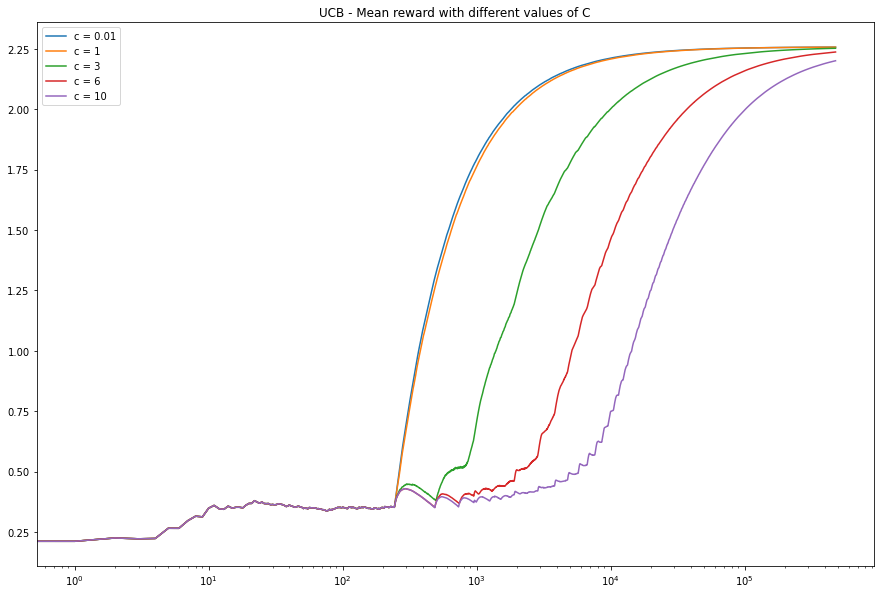

In [29]:
plt.figure(figsize=(15, 10))
plt.plot(c_values[0.01][1], label = "c = 0.01")
plt.plot(c_values[1][1], label = "c = 1")
plt.plot(c_values[3][1], label = "c = 3")
plt.plot(c_values[6][1], label = "c = 6")
plt.plot(c_values[10][1], label = "c = 10")
plt.title('UCB - Mean reward with different values of C')
plt.xscale('log')
plt.legend()
plt.show()

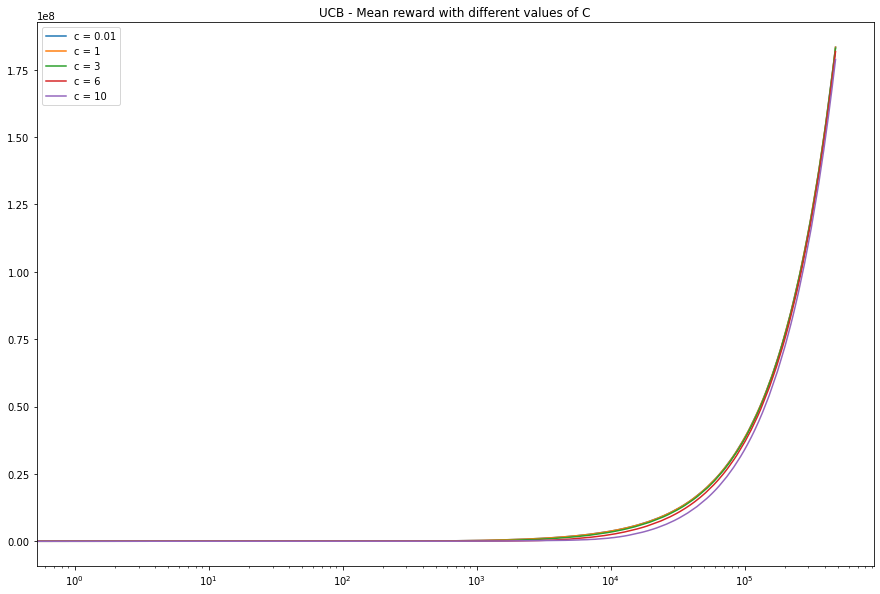

In [30]:
plt.figure(figsize=(15, 10))
plt.plot(c_values[0.01][5], label = "c = 0.01")
plt.plot(c_values[1][5], label = "c = 1")
plt.plot(c_values[3][5], label = "c = 3")
plt.plot(c_values[6][5], label = "c = 6")
plt.plot(c_values[10][5], label = "c = 10")
plt.title('UCB - Mean reward with different values of C')
plt.xscale('log')
plt.legend()
plt.show()

### Conclusions

Random algorithm: the average reward remains very stable over iterations. Total reward at the end:

$\epsilon$-greedy

$\epsilon$ = 0 performs exploit only.

Higher values ​​of $\epsilon$ (0.4, 0.7, 1), which establish more exploitative algorithms, are able to find better-rated movies earlier in iterations. However, because they are explorers, they explore more often and so, even though they have already found the films that return the highest rewards, they remain unexplored and end up reaching the medium reward plateau earlier. So, in the end, they have lower total rewards.

In contrast, lower values ​​of $\epsilon$ (0.01, 0.1), which establish less exploitative algorithms, take longer to find the movies that bring the greatest rewards. However, once they find these movies, they end up doing a lot more exploit actions, which leads to a jump in average rewards after a certain point in the iterations. The less exploitative the algorithm is, the later this jump happens. But when it does happen, the gains are dizzying, both in terms of average reward and total final reward.

In the explore scenario, with a high number of replays (500), the best algorithm was the one with the lowest epsilon (less exploitative). In a scenario with less time/resources, a more exploitative algorithm could do better, as it would find the best movies sooner.

UCB

Algorithms with different values ​​of c behave similarly up to a certain point in the iterations. At the moment when the two algorithms with the lowest values ​​of c (less exploiters) crash on the best movie and start to perform only exploit actions, there is a big jump in the average reward. The three algorithms with the highest c values ​​(more explorers) also reach this jump, but due to the explorer characteristic, they end up performing more explore actions, limiting the average reward level and total reward at the end of the iterations.

### Best $\epsilon$-greedy X Best UCB

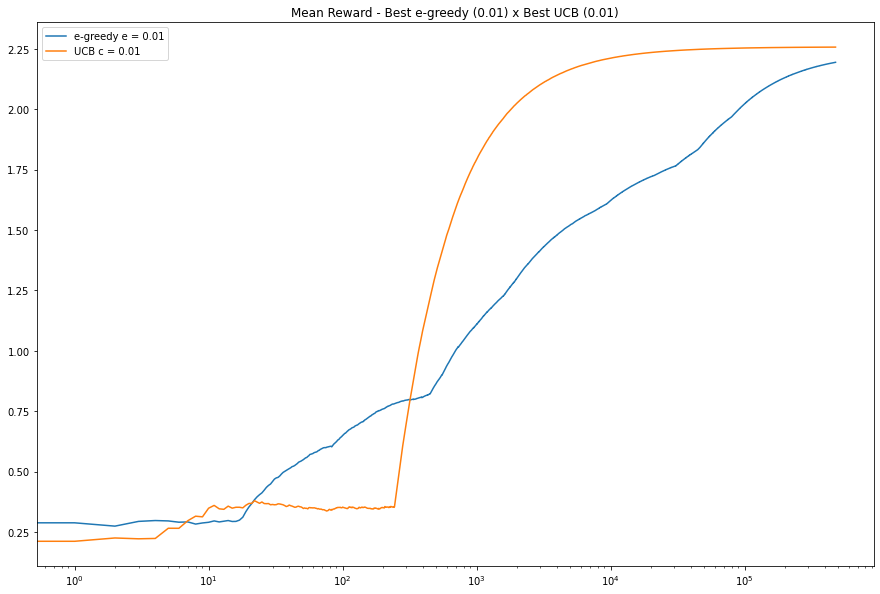

In [31]:
plt.figure(figsize=(15, 10))
plt.plot(e_values[0.01][1], label = "e-greedy e = 0.01")
plt.plot(c_values[0.01][1], label = "UCB c = 0.01")
plt.title('Mean Reward - Best e-greedy (0.01) x Best UCB (0.01)')
plt.xscale('log')
plt.legend()
plt.show()

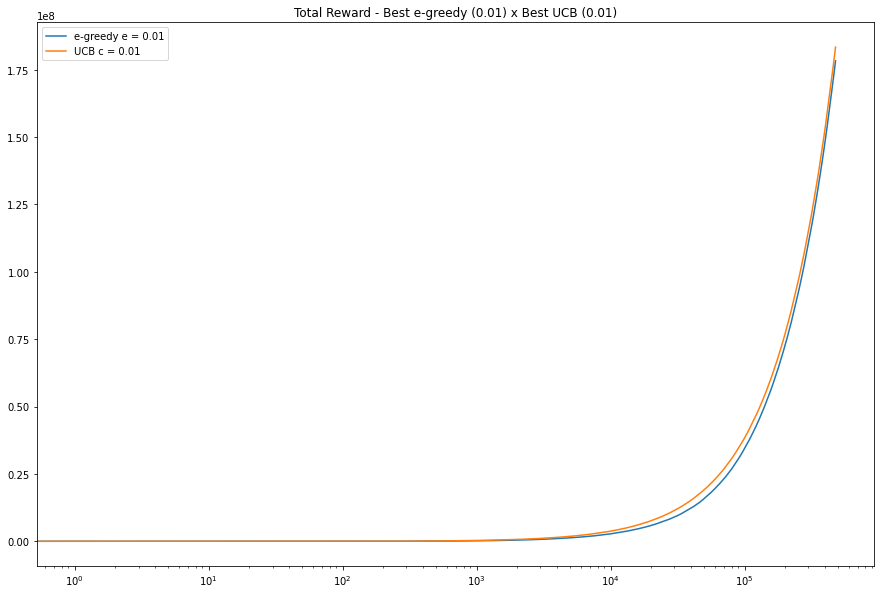

In [32]:
plt.figure(figsize=(15, 10))
plt.plot(e_values[0.01][5], label = "e-greedy e = 0.01")
plt.plot(c_values[0.01][5], label = "UCB c = 0.01")
plt.title('Total Reward - Best e-greedy (0.01) x Best UCB (0.01)')
plt.xscale('log')
plt.legend()
plt.show()

In the final comparison between the best $\epsilon$-greedy (e=0.01) and the best UCB (c=0.01), UCB did better in the end.

However, it is interesting to observe from the average reward curves that the $\epsilon$-greedy has a continuous growth over time, while the UCB remains stable for a long period and then grows dramatically. From that inflection point of the curve, the UCB is much better up to a certain point where the two arrive at a similar level of average reward.